# Training a regression with outputs shaped by Guassian

Use pytorch to take into account the correlation during the training, and force the output distributions to be shaped by a Gaussian.

## Settings

In [1]:
n_variables = 4 # Number of data and background varialbes to generate
n_samples = 10000 # Number of samples to generate

center_signal = 2.0 # Where the gaussian for signal should be
center_background = 1.0 # Where the gaussian for background should be

In [2]:
import sys
sys.path += ['../abcdlib']
import data_gen

import seaborn as sns
import pandas as pd
from torch import nn
from torch import optim
import torch
import numpy as np
import matplotlib.pyplot as plt

## Generate the data

In [3]:
sig = data_gen.generate_gaussian(n_variables, center_signal, n_samples)
back = data_gen.generate_gaussian(n_variables, center_background, n_samples)

n_training_samples = int(n_samples/2)

training = data_gen.combine(sig[:n_training_samples], back[:n_training_samples])
testing = data_gen.combine(sig[n_training_samples:], back[n_training_samples:])

## Train with two outputs and a custom loss function

For a regression, we need just a single output column with the 1 or 0 as the target value. Of course, this time we need 2 columns, duplicated.

In [4]:
label = training[training.columns[-1]].values
labels = np.stack((label, label), axis=1)

In [5]:
x_train = torch.Tensor(training[training.columns[:-1]].values)
y_train = torch.Tensor(labels)

The loss function should be a combination of the normal accuracy loss function and also the correlation on background (only), and shape the background to look like a Guassian (also only on the background).

- Use the accuracy on all the training data
- Calculate the correlation only on items marked as being background
- Turn the background variable distirbution into a z-scoare, and then match it to a guassian curve we have pre-generated.

In [6]:
def calc_dcov2(a, b):
    outer_a = a.reshape(-1, 1) - a
    outer_b = b.reshape(-1, 1) - b
    
    single_a = torch.mean(torch.abs(outer_a))
    single_b = torch.mean(torch.abs(outer_b))

    joint = torch.mean(torch.abs(outer_a)*torch.abs(outer_b))

    a_outer = abs(a[:, None] - a[None, :])
    b_outer = abs(b[:, None] - b[None, :])
    s = torch.einsum("ij,ik->", a_outer, b_outer)
    tripple = s / len(a)**3
    
    dcov2 = joint + single_a*single_b - 2*tripple
    
    return dcov2

def calc_DisCo2(prediction):
    a = prediction[:, 0]
    b = prediction[:, 1]

    return calc_dcov2(a,b)/torch.sqrt(calc_dcov2(a,a)*calc_dcov2(b,b))

class decorrelate_loss:
    '''Calculate the loss function using MSELoss and decorrelation loss
    '''
    def __init__(self):
        self._mse = nn.MSELoss(reduction='mean')
        self._unit_gaussian, _ = torch.sort(torch.randn((n_training_samples, 2)), dim=0)
        self._loss_record = []
        
    def __call__(self, prediction, labels):
        'Calc the loss given both the correlation and mse'

        # The loss for the two predictions not matching signal/background
        mse_loss = self._mse(prediction, labels)
        
        background_mask = labels[:,1] == 0
        # signal_mask = labels[:,1] == 1

        disco2 = calc_DisCo2(prediction[background_mask])

        if len(self._loss_record) < 200:
            mse_factor = 100.0
            disco_factor = 1.0
        elif len(self._loss_record) < 300:
            mse_factor = 10.0
            disco_factor = 10.0
        else:
            mse_factor = 1.0
            disco_factor = 10.0
            
        total = mse_loss*mse_factor + disco2*disco_factor
        self._loss_record.append((float(mse_loss.item()),
                                  float(disco2.item())))
        # print(total)
        return total

Next create a simple classifier - 2 layers, with the same number of nodes as inputs. It looks like doubling the size of the inputs and outputs makes a big difference, but in general getting this to train better hasn't been successful so far. No idea why.

In [7]:
model = nn.Sequential(nn.Linear(n_variables, 128),
                      nn.ReLU(),
                      nn.Linear(128, 128),
                      nn.ReLU(),
                      nn.Linear(128, 128),
                      nn.ReLU(),
                      nn.Linear(128, 128),
                      nn.ReLU(),
                      nn.Linear(128, 2))
criterion = decorrelate_loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now lets do the training

In [8]:
epocs = 0
epoc_times = []

In [9]:
%%time
epochs_to_run = 600
import timeit
for e in range(epochs_to_run):
    s_time = timeit.default_timer()
    epocs += 1
    optimizer.zero_grad()
    output = model(x_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()
    epoc_times.append(timeit.default_timer() - s_time)
    running_loss = loss.item()
    if e % 300 == 0:
        print(f'Training loss ({epocs}): {running_loss/len(x_train)}')
        print(f'  Average time for last {len(epoc_times[-10:])}: {sum(epoc_times[-10:])/len(epoc_times[-10:])} seconds')
else:
    print(f'Training loss ({epocs}): {running_loss/len(x_train)}')
    print(f'  Average time for last {len(epoc_times[-10:])}: {sum(epoc_times[-10:])/len(epoc_times[-10:])} seconds')

Training loss (1): 0.004444944000244141
  Average time for last 1: 4.789384797215462 seconds
Training loss (301): 1.794305145740509e-05
  Average time for last 10: 4.673369462508708 seconds
Training loss (600): 1.5783587098121642e-05
  Average time for last 10: 3.4031087222509084 seconds
CPU times: user 1h 40min, sys: 1h 13min 38s, total: 2h 53min 38s
Wall time: 43min 38s


In [10]:
loss_info_mse = [
    {
        'loss': mse,
        'type': 'mse',
        'epoch': i
    }
    for i, (mse, dico2) in enumerate(criterion._loss_record)
]
loss_info_disco2 = [
    {
        'loss': disco2,
        'type': 'DisCo^2',
        'epoch': i
    }
    for i, (mse, disco2) in enumerate(criterion._loss_record)
]
loss_trends = pd.DataFrame(loss_info_mse + loss_info_disco2)

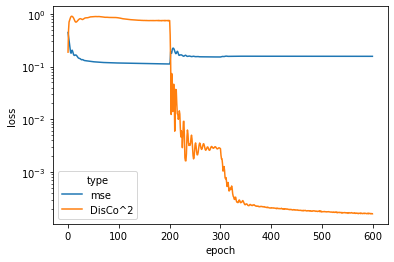

In [11]:
_ = sns.lineplot(x='epoch', y='loss', hue='type', data=loss_trends)
plt.yscale('log')

## Prediction

Get the predicted probabilities out and see where they line up and how well this guy did!

In [12]:
x_test = torch.Tensor(testing[testing.columns[:-1]].values)
y_test = model(x_test)

In [13]:
x_results = testing.copy()
x_results['Prediction_1'] = y_test.detach().numpy()[:,0]
x_results['Prediction_2'] = y_test.detach().numpy()[:,1]

<AxesSubplot:xlabel='Prediction_1', ylabel='Count'>

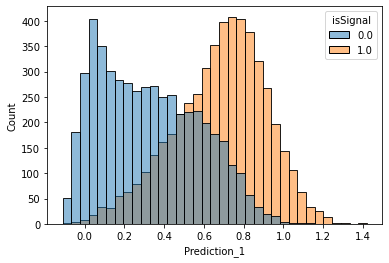

In [14]:
sns.histplot(x_results, x='Prediction_1', hue='isSignal')

<AxesSubplot:xlabel='Prediction_2', ylabel='Count'>

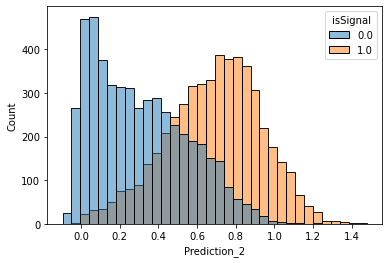

In [15]:
sns.histplot(x_results, x='Prediction_2', hue='isSignal')

Lets look at the correlation between these on background and signal data

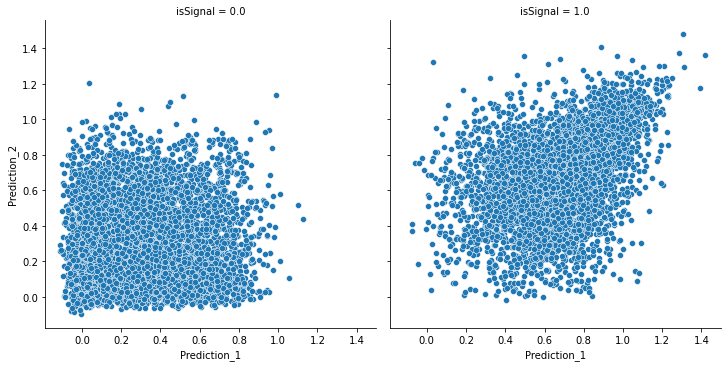

In [16]:
sns.relplot(data=x_results, x='Prediction_1', y='Prediction_2', col='isSignal')

Other than something odd going on down near zero, this looks very correlated for background (and signal). We need the background to be uncorrelated...

## Correlation for the background

Lets see what the final number of the correlation is of the background

In [17]:
def calc_r(prediction):
    mean = torch.mean(prediction, dim=0)
    std_dev = torch.std(prediction, dim=0)
    parts = (prediction - mean)
    sum = torch.sum(parts[:,0]*parts[:,1])
    return sum / std_dev[0] / std_dev[1] / (prediction.shape[0]-1)

label = torch.Tensor(testing[testing.columns[-1]].values)
mask = label == 0.0
calc_r(y_test[mask])

tensor(-0.0115, grad_fn=<DivBackward0>)